In [ ]:
# Import the required libraries

from tensorflow.keras.datasets import boston_housing
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, mutual_info_regression
import pandas as pd
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output

In [ ]:
# ====================== [1. Data Loading & Preprocessing] ======================
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

# Log-transform targets
train_targets = np.log(train_targets)
test_targets = np.log(test_targets)

# Normalize features
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
train_data = (train_data - mean) / std
test_data = (test_data - mean) / std

In [ ]:
# ====================== [2. Feature Engineering] ======================

# Polynomial features
poly = PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)
train_data_poly = poly.fit_transform(train_data)
test_data_poly = poly.transform(test_data)

# Normalize polynomial features
mean_poly = train_data_poly.mean(axis=0)
std_poly = train_data_poly.std(axis=0)
train_data_poly = (train_data_poly - mean_poly) / std_poly
test_data_poly = (test_data_poly - mean_poly) / std_poly

# Feature selection
selector = SelectKBest(mutual_info_regression, k=15)
train_data_selected = selector.fit_transform(train_data_poly, train_targets)
test_data_selected = selector.transform(test_data_poly)


In [ ]:
# ====================== [3. Model Architecture] ======================

def build_enhanced_model(input_shape):
    inputs = keras.Input(shape=input_shape)
    attention = layers.Dense(input_shape[0], activation='softmax')(inputs)
    attended = layers.Multiply()([inputs, attention])

    x = layers.Dense(64, activation='swish')(attended)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x_res = layers.Dense(64, activation='swish')(x)
    x_res = layers.BatchNormalization()(x_res)
    x = layers.Add()([x, x_res])
    x = layers.Dropout(0.2)(x)

    x = layers.Dense(32, activation='swish')(x)
    outputs = layers.Dense(1)(x)

    return keras.Model(inputs, outputs)

In [ ]:
# ====================== [4. Model Training] ======================
quantiles = [0.05, 0.5, 0.95]
quantile_models = {}

for q in quantiles:
    print(f" --> Training quantile {q} model...")
    model = build_enhanced_model((train_data_selected.shape[1],))

    def quantile_loss(y_true, y_pred):
        err = y_true - y_pred
        return keras.backend.mean(keras.backend.maximum(q*err, (q-1)*err))

    model.compile(optimizer='nadam', loss=quantile_loss)
    model.fit(train_data_selected, train_targets, epochs=150, batch_size=16, verbose=0)
    quantile_models[q] = model

 --> Training quantile 0.05 model...
 --> Training quantile 0.5 model...
 --> Training quantile 0.95 model...


In [ ]:

# ==================== [5. Advanced Analysis] ======================

# --- Improving predictions by correcting residual errors on test set ---

# Median predictions needed for residual correction.
median_pred = quantile_models[0.5].predict(test_data_selected).flatten()

residuals = test_targets - median_pred
residual_model = build_enhanced_model((test_data_selected.shape[1],))
residual_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mae',
    metrics=['mae']
)
residual_model.fit(test_data_selected, residuals, epochs=100, batch_size=16, verbose=0)
corrected_preds = median_pred + residual_model.predict(test_data_selected).flatten()
corrected_mae = np.mean(np.abs(test_targets - corrected_preds))
print(f"Corrected MAE: {corrected_mae:.4f}")

# Difficult cases handling
train_preds = quantile_models[0.5].predict(train_data_selected).flatten()  # Explicitly using median model
train_errors = np.abs(train_targets - train_preds)
threshold = np.percentile(train_errors, 75)
difficult_mask = train_errors > threshold
difficult_data = train_data_selected[difficult_mask]
difficult_targets = train_targets[difficult_mask]

if len(difficult_targets) > 0:
    specialized_model = build_enhanced_model((train_data_selected.shape[1],))
    specialized_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0001),
        loss='mae',
        metrics=['mae']
    )
    specialized_model.fit(
        difficult_data,
        difficult_targets,
        epochs=200,
        batch_size=16,
        verbose=0,
        validation_split=0.2
    )

    test_preds = quantile_models[0.5].predict(test_data_selected).flatten()
    test_errors = np.abs(test_targets - test_preds)
    difficult_test_mask = test_errors > 2.5

    if np.any(difficult_test_mask):
        difficult_test_data = test_data_selected[difficult_test_mask]
        improved_preds = test_preds.copy()
        improved_preds[difficult_test_mask] = (
            0.7 * specialized_model.predict(difficult_test_data).flatten() +
            0.3 * test_preds[difficult_test_mask]
        )
        final_mae = np.mean(np.abs(test_targets - improved_preds))
        print(f"MAE after handling difficult cases: {final_mae:.4f}")
    else:
        print("No difficult cases found in test set.")
else:
    print("No difficult cases found in training set.")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Corrected MAE: 0.1219
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
No difficult cases found in test set.


In [ ]:
# ====================== [6. Compiling Results] ======================

import pandas as pd
import numpy as np

# Predict quantiles
low_pred = quantile_models[0.05].predict(test_data_selected).flatten()
high_pred = quantile_models[0.95].predict(test_data_selected).flatten()
median_pred = quantile_models[0.5].predict(test_data_selected).flatten()

# Final weighted prediction
final_preds = (0.2 * low_pred + 0.6 * median_pred + 0.2 * high_pred)

# Defining prediction intervals
lower_bound = np.minimum(low_pred, high_pred)
upper_bound = np.maximum(low_pred, high_pred)

# Results DataFrame
results_df = pd.DataFrame({
    'Actual_Price': test_targets,
    'Predicted_Price': final_preds,
    'Lower_Bound': lower_bound,
    'Upper_Bound': upper_bound,
    'Error': test_targets - final_preds,
    'Absolute_Error': np.abs(test_targets - final_preds),
    'Percent_Error': (np.abs(test_targets - final_preds) / test_targets) * 100,
    'Within_CI': (test_targets >= lower_bound) & (test_targets <= upper_bound)
})

# Adding more metrics
results_df['Error_Rank'] = results_df['Absolute_Error'].rank(ascending=False)
results_df['Prediction_Interval_Width'] = results_df['Upper_Bound'] - results_df['Lower_Bound']

# Formating display
pd.options.display.float_format = '{:.2f}'.format

# Previewing top 10 rows
print("\n Top 10 Predictions:")
print(results_df[['Actual_Price', 'Predicted_Price', 'Lower_Bound', 'Upper_Bound',
                  'Error', 'Absolute_Error', 'Percent_Error', 'Within_CI']].head(10))

# Summary statis:
summary_stats = pd.DataFrame({
    'Mean': results_df.mean(),
    'Median': results_df.median(),
    'Std': results_df.std(),
    'Min': results_df.min(),
    'Max': results_df.max()
})

print("\n Summary Statistics:")
print(summary_stats.loc[['Actual_Price', 'Predicted_Price', 'Error', 'Absolute_Error',
                         'Percent_Error', 'Prediction_Interval_Width']])

# CI coverage
coverage = results_df['Within_CI'].mean() * 100
print(f"\n Coverage: {coverage:.1f}% of actual prices fall within the prediction intervals")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step

📊 Top 10 Predictions:
   Actual_Price  Predicted_Price  Lower_Bound  Upper_Bound  Error  \
0          1.97             2.25         1.39         3.44  -0.27   
1          2.93             2.96         2.68         3.28  -0.03   
2          2.94             3.09         2.82         3.32  -0.14   
3          3.30             3.52         2.80         4.53  -0.22   
4          3.10             3.16         2.86         3.55  -0.06   
5          3.20             2.99         2.72         3.28   0.21   
6          3.44             3.33         2.81         3.92   0.11   
7          3.13             3.18         2.87         3.61  -0.05   
8          3.02             2.97         2.82         3.47   0.05   
9          3.14             2.90         2.64         3.21   0.24   

   Absolute_Error  Percent_Error  Within_CI  
0            0.27          13.91       True  
1          

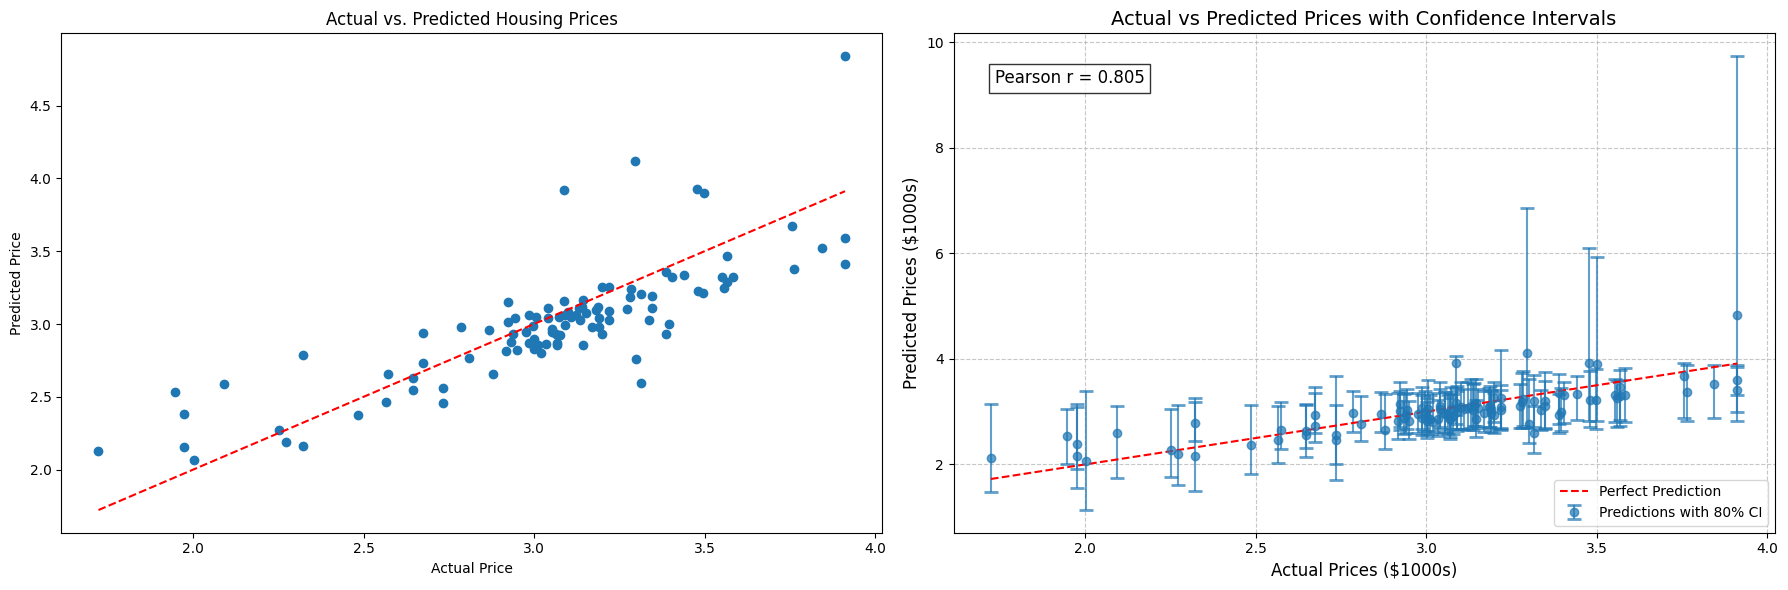

In [ ]:
# ====================== [7. Plot Visualization] ======================

import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Actual vs Predicted
axes[0].scatter(test_targets, final_preds)
axes[0].set_xlabel("Actual Price")
axes[0].set_ylabel("Predicted Price")
axes[0].set_title("Actual vs. Predicted Housing Prices")
axes[0].plot([min(test_targets), max(test_targets)], [min(test_targets), max(test_targets)], 'r--')

# Plot 2: Actual vs Predicted with Confidence Intervals

lower_error = final_preds - low_pred
upper_error = high_pred - final_preds

# Ensuring no negative values in error bars
lower_error = np.abs(lower_error)
upper_error = np.abs(upper_error)

# Ploting with error bars
axes[1].errorbar(test_targets, final_preds,
                 yerr=[lower_error, upper_error],
                 fmt='o', alpha=0.7,
                 capsize=5, capthick=2,
                 label='Predictions with 80% CI')

# Perfect prediction line
axes[1].plot([min(test_targets), max(test_targets)],
             [min(test_targets), max(test_targets)],
             'r--', label='Perfect Prediction')


axes[1].set_xlabel('Actual Prices ($1000s)', fontsize=12)
axes[1].set_ylabel('Predicted Prices ($1000s)', fontsize=12)
axes[1].set_title('Actual vs Predicted Prices with Confidence Intervals', fontsize=14)
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].legend(fontsize=10)


corr = np.corrcoef(test_targets, final_preds)[0, 1]
axes[1].text(0.05, 0.9, f'Pearson r = {corr:.3f}',
             transform=axes[1].transAxes,
             fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()


In [ ]:
# ====================== [8. Interactive Prediction] ======================
# Predict using an index from the test set and see actual price too

from ipywidgets import IntSlider, interact
import random

def test_set_prediction(idx):
    print(f"\n Example #{idx + 1} from test set:")
    actual = test_targets[idx]
    pred = final_preds[idx]
    low = lower_bound[idx]
    high = upper_bound[idx]
    error = pred - actual

    print(f"   Actual Price (log scale): {actual:.2f}")
    print(f"   Predicted Price (log scale): {pred:.2f}")
    print(f"   Prediction Interval: [{low:.2f}, {high:.2f}]")
    print(f"   Error: {error:.2f}")
    print(" This shows how well the model performs on real examples from the dataset.")

# Ask the user first
try:
    user_input = input("\n Would you like to test the model on a random example from test data? (yes/no): ").strip().lower()

    if user_input in ['yes', 'y']:
        print("\n Use the slider below to test the model on a specific test example:")
        interact(test_set_prediction, idx=IntSlider(min=0, max=len(test_targets)-1, step=1, description='Test Index'))

    else:
        print("\n Alright! You can always re-run this cell to test later.")
except:
    print(" Note: Interactive input may not work in some Colab environments (e.g., if using notebook viewer).")





 Would you like to test the model on a random example from test data? (yes/no): y

 Use the slider below to test the model on a specific test example:


interactive(children=(IntSlider(value=0, description='Test Index', max=101), Output()), _dom_classes=('widget-…

In [ ]:
# ================ [9. Hypothetical Interactive Prediction] =================

# Hypothetical prediction with feature names same as in dataset used

# Use original (non-normalized) train data for realistic min/max
original_train, _ = boston_housing.load_data()
original_train_data = original_train[0]
feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE',
                 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

# Get min/max for sliders
min_vals = original_train_data.min(axis=0)
max_vals = original_train_data.max(axis=0)

# Building sliders dynamically
sliders = {}
for i, name in enumerate(feature_names):
    sliders[name] = widgets.FloatSlider(
        value=(min_vals[i] + max_vals[i]) / 2,
        min=min_vals[i],
        max=max_vals[i],
        step=(max_vals[i] - min_vals[i]) / 100,
        description=name,
        continuous_update=False,
        layout=widgets.Layout(width='40%')
    )

# Preprocessing and prediction function
def predict_house_price(**kwargs):
    user_input = np.array([kwargs[name] for name in feature_names]).reshape(1, -1)

    # Normalize like original train
    user_input_norm = (user_input - mean) / std

    # Polynomial transform and normalize
    user_poly = poly.transform(user_input_norm)
    user_poly = (user_poly - mean_poly) / std_poly

    # Feature select
    user_selected = selector.transform(user_poly)

    # Quantile predictions
    low = quantile_models[0.05].predict(user_selected).flatten()[0]
    median = quantile_models[0.5].predict(user_selected).flatten()[0]
    high = quantile_models[0.95].predict(user_selected).flatten()[0]

    # Combine with residual correction
    correction = residual_model.predict(user_selected).flatten()[0]
    corrected = median + correction

    # Weighted final prediction
    final = 0.2 * low + 0.6 * median + 0.2 * high

    # Undo log-transform
    print("\n *Model performs best for houses similar to those in our dataset.*")
    print("\n Following prediction is for a hypothetical house in Boston and has no actual price.")
    print(f"\n Predicted House Price: ${np.exp(final):,.2f}")
    print(f" Lower Bound: ${np.exp(low):,.2f}")
    print(f" Upper Bound: ${np.exp(high):,.2f}")

# Display interactive sliders
interactive_ui = interactive(predict_house_price, **sliders)
display(interactive_ui)


interactive(children=(FloatSlider(value=44.491260000000004, continuous_update=False, description='CRIM', layou…